## Imports


In [1]:
import jax
import optax
import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state

## Transformer Block

In [2]:
class TransformerBlock(nn.Module):
  d_model: int
  heads: int
  diff: int
  dropout_rate: float = 0.1

  @nn.compact
  def __call__(self, x, training = False):
    attn_out = nn.MultiHeadDotProductAttention(
        num_heads = self.heads,
        dtype = jnp.float32
    )(x, x)
    attn_out = nn.LayerNorm()(x + attn_out)

    ff_out = nn.Sequential([
        nn.Dense(self.diff, dtype = jnp.float32),
        nn.relu,
        nn.Dense(self.d_model, dtype = jnp.float32)
    ])(attn_out)
    return nn.LayerNorm()(ff_out + attn_out)

## Reversal Transformer

In [3]:
class ReversalTransformer(nn.Module):
  d_model: int
  heads: int
  diff: int
  num_layers: int
  vocab_size: int
  max_len: int

  @nn.compact
  def __call__(self, x, training = False):
    x = nn.Embed(self.vocab_size, self.d_model)(x)
    pos = jnp.arange(0, x.shape[1], dtype = jnp.float32)[:, jnp.newaxis]
    div_term = jnp.exp(jnp.arange(0, self.d_model, 2) * -(jnp.log(10000) / self.d_model))
    pe = jnp.zeros((x.shape[1], self.d_model))
    pe = pe.at[:, 0::2].set(jnp.sin(pos * div_term))
    pe = pe.at[:, 1::2].set(jnp.cos(pos * div_term))
    x += pe[jnp.newaxis, :, :]

    for _ in range(self.num_layers):
      x = TransformerBlock(
          d_model = self.d_model,
          heads = self.heads,
          diff = self.diff,
      )(x, training = training)
    return nn.Dense(self.vocab_size)(x)


## Training Utilities

In [4]:
def create_train_state(rng, model, input_shape):
  @jax.jit
  def initialize_model(rng):
    return model.init(rng, jnp.ones(input_shape, dtype = jnp.int32))["params"]

  params = initialize_model(rng)
  tx = optax.adam(learning_rate = 1e-3)
  return train_state.TrainState.create(
      apply_fn = model.apply,
      params = params,
      tx = tx
  )

## Loss and Update Step

In [5]:
def cross_entropy_loss(logits, labels):
  one_hot_labels = jax.nn.one_hot(labels, logits.shape[-1])
  return jnp.mean(-jnp.sum(one_hot_labels * jax.nn.log_softmax(logits), axis = -1))

@jax.jit
def train_step(state, batch, target):
  def loss_fn(params):
    logits = state.apply_fn({"params": params}, batch, training = True)
    loss = cross_entropy_loss(logits, target)
    return loss

  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params)
  return state.apply_gradients(grads = grads), loss


## Create Data

In [31]:
class DataCurator:

  def __init__(self, num_sequences, max_len):
    self.num_sequences = num_sequences
    self.max_len = max_len
    self.text = [
        "I am a boy and you are a girl and this is our city to explore",
        "My name is Jon and I work at the gorcery store next door",
        "This is another test to check the learning ability of a language model during training",
        "The most effective way of checking the learning ability is to reverse the sequence",
        "I am confident that the model will work well under strenous settings",
        "Indeed the tiger belongs to the cat family and is a ferocious animal in the wild",
        "Most of the birds fly in the sky later in the evening when the sun falls down",
        "I am certain that the model has some learning ability which can be measured using this task"
    ][:self.num_sequences]

  def tokenize_sequences(self):
    self.words_to_tokens = {}
    self.tokenized_text = []
    counter = 0
    for seq in self.text:
      seq = seq.split(" ")
      tokenized_seq = []
      for word in seq:
        if word not in self.words_to_tokens:
          self.words_to_tokens[word] = counter
          counter += 1
        tokenized_seq.append(self.words_to_tokens[word])
      self.tokenized_text.append(tokenized_seq[:self.max_len])
    self.tokens_to_words = {v:k for k, v in self.words_to_tokens.items()}
    self.vocab_size = len(self.tokens_to_words)
    self.tokenized_text = jnp.array(self.tokenized_text, dtype = jnp.int32)
    return self.tokenized_text

  def generate_targets(self):
    self.targets = jnp.flip(self.tokenized_text, axis = -1)
    return self.targets


## Train and Generate

Epoch: 0 | Loss: 4.242325782775879
Epoch: 10 | Loss: 3.2694571018218994
Epoch: 20 | Loss: 2.273271083831787
Epoch: 30 | Loss: 0.985136866569519
Epoch: 40 | Loss: 0.2998259365558624
Epoch: 50 | Loss: 0.08849935978651047
Epoch: 60 | Loss: 0.036019448190927505
Epoch: 70 | Loss: 0.02056925557553768
Epoch: 80 | Loss: 0.014286713674664497
Epoch: 90 | Loss: 0.0111165139824152
Epoch: 100 | Loss: 0.00920168124139309
Epoch: 110 | Loss: 0.007902028039097786
Epoch: 120 | Loss: 0.006934502627700567
Epoch: 130 | Loss: 0.006171971559524536
Epoch: 140 | Loss: 0.0055457004345953465
Epoch: 150 | Loss: 0.005018028896301985
Epoch: 160 | Loss: 0.004569504875689745
Epoch: 170 | Loss: 0.004183555021882057
Epoch: 180 | Loss: 0.0038488039281219244
Epoch: 190 | Loss: 0.003555705538019538
Epoch: 200 | Loss: 0.0032972844783216715
Epoch: 210 | Loss: 0.003068018238991499
Epoch: 220 | Loss: 0.00286365719512105
Epoch: 230 | Loss: 0.0026800676714628935
Epoch: 240 | Loss: 0.0025146317202597857
Epoch: 250 | Loss: 0.0023

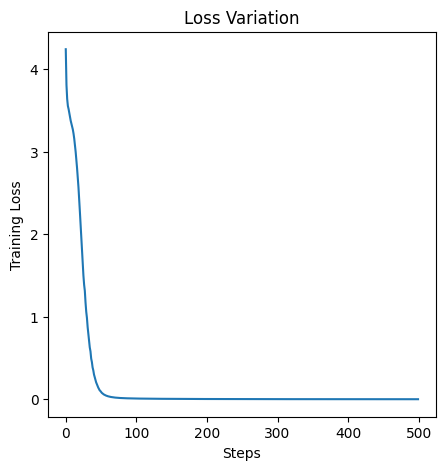

['the', 'is', 'This', 'This', 'This', 'This', 'of', 'and', 'My', 'am']


In [33]:
def main():
  max_len = 10
  num_sequences = 5
  d_model = 128
  diff = 64
  heads = 2
  layers = 2
  epochs = 500
  evals = 1000

  dataset = DataCurator(num_sequences, max_len)
  batch = dataset.tokenize_sequences()
  targets = dataset.generate_targets()

  model = ReversalTransformer(
      d_model = d_model,
      heads = heads,
      diff = diff,
      num_layers = layers,
      vocab_size = dataset.vocab_size,
      max_len = max_len
  )
  rng = jax.random.PRNGKey(42)
  rng, init_rng = jax.random.split(rng)
  state = create_train_state(
      init_rng,
      model,
      input_shape = (num_sequences, max_len)
  )

  losses = []
  for i in range(epochs):
    state, loss = train_step(state, batch, targets)
    losses.append(loss)

    if i % 10 == 0:
      print(f"Epoch: {i} | Loss: {loss}")

  plt.figure(figsize = (5, 5))
  plt.plot([j for j in range(len(losses))], losses)
  plt.title("Loss Variation")
  plt.xlabel("Steps")
  plt.ylabel("Training Loss")
  plt.show()

  prompt = ["the"]
  for i in range(max_len - 1):
    input = jnp.array([dataset.words_to_tokens[i] for i in prompt])[jnp.newaxis,:]
    logits = state.apply_fn({"params": state.params}, input)
    idx = jnp.argmax(logits, axis = -1)[-1][-1].item()
    prompt = prompt + [dataset.tokens_to_words[idx]]
  print(prompt)


if __name__ == "__main__":
  main()
